## Imports

In [40]:
import numpy as np
import subprocess
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import array
import csv
import time

# import deap packages required
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import pandas as pd

## Load test instance 

In [41]:
myinst = "./artGalleryTestInstances/rooms.csv"

instance_file = myinst
instance_size  = 100
num_cells = instance_size * instance_size # total number of cells in the grid

# create a grid that specifies the walls that can be used later to check that no cameras are positioned on walls
walls = np.zeros(instance_size * instance_size)

with open(myinst) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter = ',')
    for line in csv_reader:
        column = int(line[0])
        row = int(line[1])
        oneD_index = (row * instance_size) + column
        walls[oneD_index] = 1

## Executables wrappers

In [42]:
path_binary = "ECO-Coursework-Executables/bit_cam_napier.exe"
path_binary_vis = "ECO-Coursework-Executables/bit_cam_napier_visualisation.exe"

# Do NOT modify this code - this calls an external binary with a solution
def objective_function(x, instance_size, nb_cameras, instance_file):
    params = ['%.16g' % a for a in x]
    cmd = [path_binary,str(instance_size),str(nb_cameras)]+params+[instance_file]
    s = subprocess.check_output(cmd)
    return float(s)


# Do NOT modify: this checks whether a camera is positioned on top of wall in a solution
def check_walls(solution, inst):
    clashes=0
    for i in range(0, len(solution)):
        if (walls[i] == 1 and solution[i]==1):
            clashes+=1
            
    return(clashes)

## Individual initialisation

In [43]:
max_cameras = 300
compressed_grid_size = 50
compressed_cells = compressed_grid_size * compressed_grid_size
full_grid_size = 100
full_grid_cells = full_grid_size * full_grid_size

def generate_individual():
    nb_cam = random.randint(1, max_cameras)
    individual = np.zeros(compressed_cells)
    # select which positions should have cameras
    indexes = random.sample(range(0, compressed_cells), nb_cam)
    for j in indexes:
        individual[j] = 1

    full_solution = convert_compressed_to_full(individual)

    if len(cameras_on_walls(full_solution)) > 0:
        repair_solution(full_solution)
        individual = convert_full_to_compressed(full_solution)

    return individual

def convert_compressed_to_full(individual):
    solution = [0] * full_grid_cells

    for i in range(len(individual)):
        if individual[i] == 1:
            # Determine the row and column in the compressed grid
            row_compressed = i // compressed_grid_size
            col_compressed = i % compressed_grid_size
            
            # Calculate the top-left index of the corresponding 2x2 block in the full grid
            top_left_index = (row_compressed * 2 * full_grid_size) + (col_compressed * 2)
            
            # Set the top-left cell in the 2x2 block
            solution[top_left_index] = 1

    return solution

def convert_full_to_compressed(solution):
    individual = []
    
    # Iterate through 2x2 blocks
    for i in range(0, full_grid_size, 2):  # Rows
        for j in range(0, full_grid_size, 2):  # Columns
            # Calculate indices of the 2x2 block
            top_left = i * full_grid_size + j
            top_right = top_left + 1
            bottom_left = top_left + full_grid_size
            bottom_right = bottom_left + 1
            
            # Determine the compressed value for this block
            if (
                solution[top_left] == 1 or
                solution[top_right] == 1 or
                solution[bottom_left] == 1 or
                solution[bottom_right] == 1
            ):
                individual.append(1)
            else:
                individual.append(0)
    
    return individual


## Repair function

In [44]:
def cameras_on_walls(solution):
    positions = []
    for i in range(0, len(solution)):
        if (walls[i] == 1 and solution[i] == 1):
            positions.append(i)
            
    return(positions)

# delete all cameras that are on the walls 
def repair_solution(solution):
    clash_positions = cameras_on_walls(solution)

    for pos in clash_positions:
        solution[pos] = 0

def add_single_camera(individual):
    position = random.randint(0, compressed_cells)
    individual[position] = 1

## Evaluation function

In [45]:
def eval_function(individual):
    solution = []
    total_cameras = 99999
    fitness = total_cameras

    # convert individual to the solution list - this depends on the representation
    solution = convert_compressed_to_full(individual)

    # make sure there's at least one camera
    if sum(solution) < 1:
        add_single_camera(individual)
    
    # check if cameras on walls
    if instance_file == "":
        cameras_on_walls = 0
    else:
        cameras_on_walls = check_walls(solution, instance_file) 

    if cameras_on_walls > 0:
        repair_solution(solution)
        individual = convert_full_to_compressed(solution)

    total_cameras = np.sum(solution)

    not_covered_penalty_factor = 15000

    # only call this if the solution is not invalid
    coverage = objective_function(solution, instance_size, total_cameras, instance_file)

    if coverage < 0.99:
        fitness = not_covered_penalty_factor  
    else:
        fitness = total_cameras 

    return fitness,

## Setup the EA

In [46]:
# SETUP THE EA
# define the fitness class and creare an individual class
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


# create a toolbox
toolbox = base.Toolbox()

toolbox.register("individual", lambda: creator.Individual(generate_individual()))

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# register all operators we need with the toolbox
toolbox.register("evaluate", eval_function)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=2)

c:\Users\julka\anaconda3\envs\eco\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\julka\anaconda3\envs\eco\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


## Main EA definition

In [ ]:
population = 50
generations = 50
def main():
    
    # choose a population size: e.g. 200
    pop = toolbox.population(n=population)
    
    # keep track of the single best solution found
    hof = tools.HallOfFame(1)
 
    # create a statistics object: we can log what ever statistics we want using this. We use the numpy Python library
    # to calculate the stats and label them with convenient labels
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    # run the algorithm: we need to tell it what parameters to use
    # cxpb = crossover probability; mutpb = mutation probability; ngen = number of iterations
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.6, mutpb=0.05, ngen=generations, stats=stats, halloffame=hof, verbose=True)
    
    return pop, log, hof

## Hill climber

In [48]:
def get_all_camera_positions(solution):
    return [i for i, value in enumerate(solution) if value == 1]

# delete a random camera
def generate_neighbouring_solution(solution):
    new_solution = solution.copy()
    all_cameras = get_all_camera_positions(new_solution)
    chosen = random.choice(all_cameras)
    new_solution[chosen] = 0

    return new_solution

def generate_valid_neighbours(solution):
    valid_neighbours = []
    all_cameras = get_all_camera_positions(solution)
    for cam in all_cameras:
        neighbour = solution.copy()
        neighbour[cam] = 0
        converted = convert_compressed_to_full(neighbour)
        cams = np.sum(neighbour)
        coverage = objective_function(converted, instance_size, cams, instance_file)
        if coverage > 0.99:
            valid_neighbours.append((cam, coverage))

    print(valid_neighbours)

    return valid_neighbours


def pick_a_neighbour(neighbours):
    sorted_neighbours = sorted(neighbours, key=lambda x: x[1], reverse=True)
    best_neighbour = sorted_neighbours[0]
    highest_items = [item for item in sorted_neighbours if item[1] == best_neighbour[1]]
    
    return random.choice(highest_items)


def hill_climber(solution):
    best_solution = solution
    min_num_cameras = np.sum(solution)
    initial_min_cameras = min_num_cameras

    # set the maximum number of tries
    max_tries = 100
    
    # now run the HC loop : 
    for i in range(max_tries-1):
        valid_neighbours = generate_valid_neighbours(best_solution)
        if len(valid_neighbours) <= 0:
            break
        
        chosen_neighbour = pick_a_neighbour(valid_neighbours)
        
        new_solution = best_solution.copy()
        new_solution[chosen_neighbour[0]] = 0
        new_coverage = chosen_neighbour[1]
        new_cameras = np.sum(new_solution)

        print(f"{i} Generated cameras: {new_cameras}, coverage: {new_coverage}")
        
        if new_coverage > 0.99:
            print("accepted new")
            min_num_cameras = new_cameras
            best_solution = new_solution.copy()

    print("Starting camera number %s Best found %s improvement of %s" % (initial_min_cameras, min_num_cameras, initial_min_cameras-min_num_cameras))  
   
    # return the results
    return best_solution

## Run the EA

In [ ]:
for run in range(0, 10):
    start = time.time()
    pop, log, hof = main()
    stop = time.time()

    run_time = stop - start

    best = hof[0].fitness.values[0]   # best fitness found is stored at index 0 in the hof list

    # look in the logbook to see what generation this was found at
    min = log.select("min")  # max fitness per generation stored in log

    for i in range(generations):  # set to ngen
            fit = min[i]
            if fit == best:
                break              
    
    print("min fitness found is %s at generation %s" % (best, i))

    best_after_hc = hill_climber(hof[0])
    hc_best_cameras = np.sum(best_after_hc)

    with open("output.csv", mode = "a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([best, i, best_after_hc, run_time]) 

gen	nevals	avg   	std    	min	max  
0  	10    	1657.8	4447.96	80 	15000
1  	4     	3091.3	5954.71	80 	15000
2  	6     	86.5  	7.78781	75 	103  
3  	8     	81.7  	3.63456	75 	86   
4  	4     	80.6  	2.87054	75 	85   
5  	2     	80.3  	2.5318 	75 	84   
6  	4     	80.3  	1.67631	77 	82   
7  	4     	79.3  	1.00499	78 	82   
8  	8     	78.6  	0.916515	77 	80   
9  	6     	1570.4	4476.53 	77 	15000
10 	4     	78    	2       	75 	83   
min fitness found is 75.0 at generation 2
[(12, 1.0), (104, 1.0), (158, 1.0), (239, 1.0), (246, 1.0), (258, 1.0), (313, 1.0), (423, 1.0), (428, 1.0), (432, 1.0), (480, 1.0), (482, 1.0), (531, 1.0), (554, 1.0), (706, 1.0), (711, 1.0), (714, 1.0), (716, 1.0), (754, 1.0), (781, 1.0), (785, 1.0), (922, 1.0), (980, 1.0), (1034, 1.0), (1045, 1.0), (1056, 1.0), (1101, 1.0), (1109, 1.0), (1144, 1.0), (1189, 1.0), (1232, 1.0), (1300, 1.0), (1348, 1.0), (1387, 1.0), (1397, 1.0), (1417, 1.0), (1518, 1.0), (1532, 1.0), (1533, 1.0), (1560, 1.0), (1565, 1.0), (1571, 1.0), 

KeyboardInterrupt: 

## Visualise solution and statistics

Original EA output
42
0.991299
0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

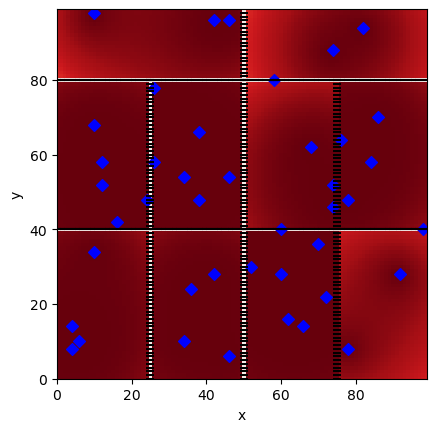

Hill climber output
24
0.990041
0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

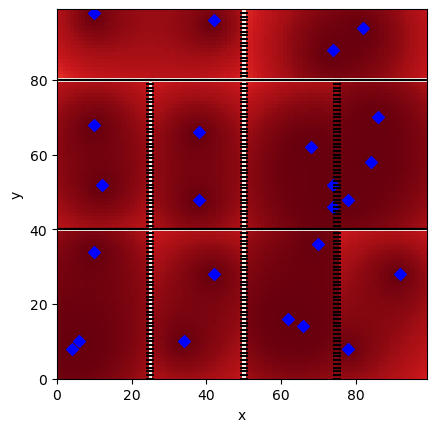

In [ ]:
# Run this cell to define the functions
def solution_converter(index, instance_size):
    counter = 0
    for i in range(instance_size):
        for j in range(instance_size):
            if (counter == index):
                return i,j
            else:
                counter+=1

# assumes path_binary is already set 
def visualise_objective_function(x, instance_size, nb_cameras, instance_file):
    params = ['%.16g' % a for a in x]
    cmd = [path_binary_vis,str(instance_size),str(nb_cameras)]+params+[instance_file]
    with open("temp_results.csv",'w') as fd:
        s = subprocess.call(cmd, stdout=fd)
    # Plotting the probability of detection
    data = pd.read_csv("temp_results.csv")
    values = np.array(data["value"])
    values[values < 0.5] = 0
    values = values.reshape(instance_size,instance_size)
    plt.imshow(values,cmap="Reds")
    # Plotting cameras
    cameras_indices = [index for (index, item) in enumerate(list(x)) if item == 1]
    for c in cameras_indices:
        x,y = solution_converter(c, instance_size=instance_size)
        plt.scatter(y,x,c="blue",marker="D")
    # Plotting walls (if any)
    if (instance_file != ""):
        walls = pd.read_csv(instance_file,header=None)
        plt.scatter(walls[1],walls[0],c="black", marker="_")
    plt.xlim(0,instance_size-1)
    plt.xlabel("x")
    plt.ylim(0,instance_size-1)
    plt.ylabel("y")
    plt.show()
    
# Here we just create a random solution for a 100x100 grid with two cameras at random positions
# you can experiment to see what different solutions look like

# choose an empty grid
#visualise_objective_function(sol, instance_size= 100, nb_cameras=2, instance_file="")


# visualise the original solution
print("Original EA output")
final_solution = hof[0]
final_solution = convert_compressed_to_full(final_solution)
actual_cameras=sum(final_solution)  # need to pass the actual numbers of cameras in the solution, regardless of whether it is valid
print(actual_cameras)
coverage = objective_function(final_solution, instance_size, actual_cameras, instance_file)
print(coverage)
cameras_on_walls = check_walls(final_solution, instance_file) 
print(cameras_on_walls)
print(final_solution)

visualise_objective_function(final_solution, instance_size=instance_size, nb_cameras=actual_cameras, instance_file=myinst)

# visualise the hill climber output
print("Hill climber output")
final_solution_hc = best_after_hc
final_solution_hc = convert_compressed_to_full(final_solution_hc)
actual_cameras_hc=sum(final_solution_hc)  # need to pass the actual numbers of cameras in the solution, regardless of whether it is valid
print(actual_cameras_hc)
coverage_hc = objective_function(final_solution_hc, instance_size, actual_cameras_hc, instance_file)
print(coverage_hc)
cameras_on_walls_hc = check_walls(final_solution_hc, instance_file) 
print(cameras_on_walls_hc)
print(final_solution_hc)

visualise_objective_function(final_solution_hc, instance_size=instance_size, nb_cameras=actual_cameras_hc, instance_file=myinst)


C:\Users\julka\AppData\Local\Temp\ipykernel_14640\2919038694.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  line1 = ax1.plot(gen, fit_max, "b-", label="max Fitness", color="r")
C:\Users\julka\AppData\Local\Temp\ipykernel_14640\2919038694.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  line2 = ax1.plot(gen, fit_min, "b-", label="min Fitness", color="b")
C:\Users\julka\AppData\Local\Temp\ipykernel_14640\2919038694.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  line3 = ax1.plot(gen , fit_avg, "b-", label="avg Fitness", color="g")


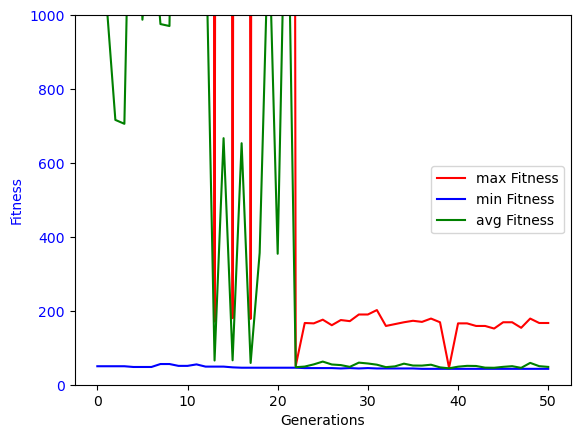

In [ ]:
# code for plotting

gen = log.select("gen")
fit_max = log.select("max")
fit_min = log.select("min")
fit_avg = log.select("avg")

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, fit_max, "b-", label="max Fitness", color="r")
line2 = ax1.plot(gen, fit_min, "b-", label="min Fitness", color="b")
line3 = ax1.plot(gen , fit_avg, "b-", label="avg Fitness", color="g")
ax1.set_xlabel("Generations")
ax1.set_ylabel("Fitness", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")
ax1.set_ylim(0,1000)
    
lns = line1+line2+line3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center right")
